# Generate synthetic data
Generating synthetic data using public libraries for the 'adult' dataset.

## Load libraries and define settings

In [15]:
# general dependencies
import numpy as np
import pandas as pd
import sys
import os
from pathlib import Path

# synthesis methods
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.benchmark import Benchmarks

from synthesis.synthesizers.privbayes import PrivBayes
from synthesis.evaluation.metrics import MarginalComparison, AssociationsComparison

# repo code
from crnsynth.configs import config
from crnsynth.synth.custom_generators.privbayes_dk import PrivBayesDK
from crnsynth.synth.custom_generators.marginal_dk import MarginalDK
from crnsynth.synth.custom_generators.uniform_dk import UniformDK

from crnsynth.process import util
from crnsynth.evaluation import visual
from crnsynth.synth.synthpipe import BaseSynthPipe

# gives extra pandas methods for dataframes: bin_numeric_column, sample_from_binned_column
from synthesis.transformers import deidentification, generalization


In [16]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# privacy budget for differentially private algorithms
EPSILON = 1

# dataset
DATASET_NAME = 'adult'

## Load and process dataset

In [18]:
df_adult = pd.read_csv(config.PATH_DATA[DATASET_NAME])
df_adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Generate
Here we show how step by step how to generate synthetic data.

We define our synthesis pipeline, this will help us perform all the steps the right order. You can inherit common functionality across synthesis pipelines, while also adding your own data-specific methods to it. 

This ensures that you can benefit from a defined structure without needing to re-implement the generic elements, while still having the flexbility to customize it to your needs.

In [19]:
class AdultSynthPipe(BaseSynthPipe):
    def __init__(
        self,
        generator,
        data_name="adult",
        target_column="income",
        test_size=0.2,
        output_train_format=False,
        generalize=True,
        data_loader_name="generic",
        random_state=None,
        warn=True,
        verbose=2,
    ) -> None:
        super().__init__(
            generator=generator,
            data_name=data_name,
            target_column=target_column,
            test_size=test_size,
            output_train_format=output_train_format,
            generalize=generalize,
            data_loader_name=data_loader_name,
            random_state=random_state,
            warn=warn,
            verbose=verbose,
        )

    def process_data(self, data_real):
        # reduce columns
        columns_subset = [
            "age",
            "workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "hours-per-week",
            "native-country",
            "income",
        ]
        data_real = data_real[columns_subset]

        return super().process_data(data_real)

    def _generalize_data(self, data_real):
        data_real = data_real.bin_numeric_column(
            column_name="age", n_bins=5, col_min=17, col_max=90, strategy="quantile"
        ).bin_numeric_column(
            column_name="hours-per-week",
            n_bins=5,
            col_min=1,
            col_max=99,
            strategy="quantile",
        )
        return super()._generalize_data(data_real)

    def _reverse_generalization(self, data_synth):
        data_synth = data_synth.sample_from_binned_column(
            column_name="age",
            numeric_type="int",
            mean=38,
            std=13,
            random_state=self.random_state,
        ).sample_from_binned_column(
            column_name="hours-per-week",
            numeric_type="int",
            mean=40,
            std=10,
            random_state=self.random_state,
        )
        return super()._reverse_generalization(data_synth)


# choose generator
# generator = Plugins().get('privbayes-dk', epsilon=EPSILON)
generator = Plugins().get('marginal-dk', epsilon=EPSILON)

# initialize custom pipeline for dataset
synth_pipe = AdultSynthPipe(generator=generator)

[2024-01-11T09:51:45.590729+0100][2279][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py


Now we will prepare the data and split into training and testing. It's good to leave some holdout data that that can be used to compare the perfomance of models trained on real data and synthetic data.

In [20]:
# create copy to retain original data format
df = df_adult.copy()

# prepare data
df_train, df_test = synth_pipe.process_data(df)
df_train.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
29101,19,?,Some-college,Never-married,?,Other-relative,White,Female,30,United-States,<=50K
10606,50,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,<=50K
9414,62,Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States,<=50K
1747,20,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K
10677,25,Private,Bachelors,Never-married,Adm-clerical,Own-child,White,Female,40,United-States,<=50K


Train the generator on the processed training data. It might give some warning on categoreis that occur quite infrequently and might be a privacy risk to leave in your data. Decide how you would like to deal with them or proceed.

In [21]:
# train generator
synth_pipe.fit(df_train)

Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
Marginal fitted: age
Marginal fitted: workclass
Marginal fitted: education
Marginal fitted: marital-status
Marginal fitted: occupation
Marginal fitted: relationship
Marginal fitted: race
Marginal fitted: sex
Marginal fitted: hours-per-week
Marginal fitted: native-country
Marginal fitted: income


After training the synthesizer, we can now sample records from it to generate a synthetic dataset.

In [22]:
# generate synthetic data
df_synth = synth_pipe.generate(n_records=None)
df_synth.head()

Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income
Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income


,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,21,Private,HS-grad,Married-civ-spouse,Adm-clerical,Own-child,White,Male,54,United-States,>50K
1,47,Private,11th,Married-civ-spouse,Craft-repair,Own-child,White,Male,43,United-States,<=50K
2,23,Private,HS-grad,Never-married,Transport-moving,Own-child,White,Male,49,United-States,<=50K
3,24,Private,11th,Divorced,Craft-repair,Wife,White,Male,45,United-States,<=50K
4,35,Private,HS-grad,Never-married,Armed-Forces,Husband,White,Female,26,United-States,<=50K


We still might have to do some post-processing to fix inconsistencies, reorder columns or add columns.

In [23]:
# post-process data
df_synth = synth_pipe.postprocess_synthetic_data(df_synth)

df_synth.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,21,Private,HS-grad,Married-civ-spouse,Adm-clerical,Own-child,White,Male,54,United-States,>50K
1,47,Private,11th,Married-civ-spouse,Craft-repair,Own-child,White,Male,43,United-States,<=50K
2,23,Private,HS-grad,Never-married,Transport-moving,Own-child,White,Male,49,United-States,<=50K
3,24,Private,11th,Divorced,Craft-repair,Wife,White,Male,45,United-States,<=50K
4,35,Private,HS-grad,Never-married,Armed-Forces,Husband,White,Female,26,United-States,<=50K


SynthPipe allows you to perform a full synthesis pipeline step by step and allow you to inspect what happens. However, you can also use run() to perform all steps in order at once.

In [11]:
# choose generator
generator = Plugins().get('privbayes-dk', epsilon=EPSILON)

# initialize custom pipeline for dataset
synth_pipe = AdultSynthPipe(generator=generator, output_train_format=True)

df_synth_pb = synth_pipe.run(df_adult)

[2024-01-08T20:48:47.710845+0100][16982][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
1/11 - Root of network: relationship

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'marital-status' - with parents: ('relationship',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 14
Selected attribute: 'age' - with parents: ('marital-status',)

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 21
Selected attribute: 'sex' - with parents: ('relationship', 'marital-status')

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 24
Selected attribute: 'income' - with parents: ('sex', 'relationship', 'age')

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 29
Selected attribute: 'occupation' - with parents: ('sex', 'income')

7/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 2

invalid value encountered in divide
invalid value encountered in divide


Number of records generated: 26048 / 26048
Synthetic Data Generated

Number of records generated: 26048 / 26048
Synthetic Data Generated



,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,Self-emp-inc,Bachelors,Separated,Exec-managerial,Unmarried,White,Female,43,United-States,<=50K
1,60,Without-pay,Masters,Divorced,Tech-support,Not-in-family,Asian-Pac-Islander,Male,48,United-States,<=50K
2,23,Private,Some-college,Never-married,Other-service,Unmarried,White,Female,38,Mexico,<=50K
3,20,Private,10th,Never-married,Sales,Own-child,White,Male,46,United-States,<=50K
4,31,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,24,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
26043,70,Private,Assoc-acdm,Divorced,Other-service,Not-in-family,White,Female,34,Portugal,<=50K
26044,33,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,49,United-States,<=50K
26045,34,Private,HS-grad,Divorced,Other-service,Not-in-family,White,Female,33,United-States,<=50K
26046,43,Private,Masters,Divorced,Prof-specialty,Other-relative,White,Male,60,United-States,>50K


Note: PrivBayes implementation of synthetic-data-generation library (DK) is added to plugins. This version of privbayes differs with the one included synthcity:
- R score function instead of Mutual Information - which has a lower sensitivity and thus requires less noise to compute.
- Candidate attribute-parent pairs (AP-pairs) are determined based on the theta-usefulness criterion instead of setting a fixed max degree K.

## Metrics
Below an example on how to compute a privacy metric. Note the synthetic score (DCR and NNDR) > test score to minimize privacy leakage.

In [24]:
from crnsynth.evaluation.custom_privacy_metrics.dcr import DistanceClosestRecord
from crnsynth.evaluation.custom_privacy_metrics.nndr import NearestNeighborDistanceRatio

# convert to dataloaders
loader_train = GenericDataLoader(df_train)
loader_test = GenericDataLoader(df_test)
loader_synth = GenericDataLoader(df_synth)

# calculate metrics
# specify quantile for DCR, default is 0.05 (5th percentile) as we are most interested in distance of the closest records.
# set to 0.50 for median
quantile = 0.05
dcr = DistanceClosestRecord(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth, X_test=loader_test)

print(f"DCR synthetic: {dcr['dcr_synth']:.3f}")
print(f"DCR test: {dcr['dcr_gt']:.3f}")

nndr = NearestNeighborDistanceRatio(quantile=quantile).evaluate(X_gt=loader_train, X_syn=loader_synth, X_test=loader_test)
print(f"NNDR synthetic: {nndr['nndr_synth']:.3f}")
print(f"NNDR test: {nndr['nndr_gt']:.3f}")

DCR synthetic: 0.375
DCR test: 0.000
NNDR synthetic: 0.667
NNDR test: 0.000


Test distances [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]
Synthetic distances: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0.5, 1.0, 'Distribution of distances to nearest neighbor')

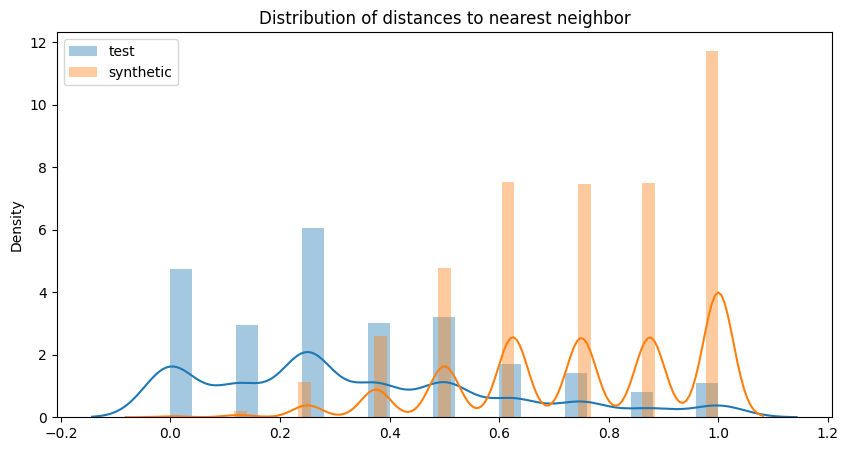

In [62]:
from crnsynth.evaluation.custom_privacy_metrics.utils import compute_distance_nn
import matplotlib.pyplot as plt
import seaborn as sns

distances_test, distances_synth = compute_distance_nn(
    df_train=df_train,
    df_test=df_test,
    df_synth=df_synth,
    categorical_cols=None,
)

# print distances test and synthetic with counts
dt, ct  = np.unique(distances_test[:, 0], return_counts=True)
dt, ct = np.unique(distances_synth[:, 0], return_counts=True)


print(f'Test distances {dt} with counts {ct}')
print(f'Synthetic distances: {dt} with counts {ct}')

# plot distances as distribution in same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(distances_test[:, 0], ax=ax, label='test')

# plot 5th percentile  and median test
percentile_test = np.percentile(distances_test[:, 0], percentile)
median_test = np.median(distances_test[:, 0])
ax.axvline(percentile_test, color='red', label=f'{percentile}th percentile')
ax.axvline(median_test, color='green', label='median')

sns.distplot(distances_synth[:, 0], ax=ax, label='synthetic')
# plot median synthetic
median_synth = np.median(distances_synth[:, 0])

ax.legend()
ax.set_title(f'Distribution of distances to nearest neighbor')

In [26]:
distances_synth

array([[0.875, 1.   ],
       [0.625, 0.75 ],
       [0.375, 0.375],
       ...,
       [0.75 , 0.875],
       [0.5  , 0.625],
       [0.375, 0.375]])

In [27]:
distances_test

array([[0.   , 0.125],
       [1.   , 1.   ],
       [0.375, 0.625],
       ...,
       [0.875, 0.875],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ]])

In [32]:
np.percentile(distances_test[:, 0], 50)

0.25

In [37]:
np.percentile(distances_synth[:, 0], 50)

0.7499999999999998

In [39]:
np.unique(distances_test[:, 0], return_counts=True)

(array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 array([1240,  766, 1576,  788,  836,  441,  372,  207,  287]))

In [48]:
df_concat_unique = pd.concat([df_train.drop_duplicates(keep=False), df_test])
df_dup = df_concat_unique[df_concat_unique.duplicated(keep='first')]

In [49]:
df_dup

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
13077,57,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,<=50K
21997,34,Private,HS-grad,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,<=50K
22684,54,Private,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K
8964,22,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,30,United-States,<=50K
8215,22,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
24643,53,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,46,United-States,>50K
7672,33,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,<=50K
14344,19,?,Some-college,Never-married,?,Own-child,White,Female,40,United-States,<=50K
8270,43,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,>50K
